# Create & deploy a Deep learning model into WML for Image Classification

#### *The sample data has 30 images across three categories for training, 9 images across three categories for validation & 6 images across three classes for testing. This is to demonstrate the methodology to create and deploy a Keras model to Watson Machine Learning for Image Classification.*

### Install specified versions of the deep learning frameworks

In [1]:
!pip install 'tensorflow==1.5' --force-reinstall
!pip install 'numpy==1.16.4'  --force-reinstall

     |████████████████████████████████| 44.4MB 2.3MB/s eta 0:00:01
     |████████████████████████████████| 1.2MB 40.4MB/s eta 0:00:01
     |████████████████████████████████| 102kB 38.8MB/s ta 0:00:01
     |████████████████████████████████| 20.4MB 39.8MB/s eta 0:00:01
     |████████████████████████████████| 3.0MB 51.7MB/s eta 0:00:01
     |████████████████████████████████| 583kB 53.1MB/s eta 0:00:01
     |████████████████████████████████| 890kB 57.0MB/s eta 0:00:01
     |████████████████████████████████| 92kB 32.4MB/s eta 0:00:01
     |████████████████████████████████| 337kB 52.7MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/ee/98/38/46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Stored in directory: /home/dsxuser/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built absl-py html5lib
  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.

## Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import ibm_boto3
from botocore.client import Config

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Using TensorFlow backend.


 #### *Sample images data has been resized to 32 x 32 pixels & converted to numpy array and class has been assigned per below. The data has been reformated & pickled to be consumed by the Watson Machine Learning Model.*

In [3]:
import pandas as pd 
   
source_data = [['balasana', 0], ['garudasana', 1], ['padangusthasana', 2]]  
df = pd.DataFrame(source_data, columns = ['Posture_name', 'Class']) 
df

,Posture_name,Class
0,balasana,0
1,garudasana,1
2,padangusthasana,2


## Insert train.pkl file as credentials. Data includes 30 images for three classes

In [5]:
from ibm_botocore.client import Config
import ibm_boto3

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

## Download the file from cloud object storage

In [6]:
cos.download_file(Bucket=credentials['BUCKET'],Key='train.pkl',Filename='/home/dsxuser/work/train.pkl')

## Set working directory

In [7]:
cd '/home/dsxuser/work/'

/home/dsxuser/work


## Unpickle the file

In [8]:
import pickle

pkl_file = open('train.pkl', 'rb')

train_data = pickle.load(pkl_file)
pkl_file.close()

## Split the file to input(x) and target(y) variables

In [9]:
trainx, trainy = train_data

## Insert validation.pkl file as credentials. Data inclues 9 images for three classes

## Download the file from cloud object storage

In [11]:
cos.download_file(Bucket=credentials['BUCKET'],Key='validation.pkl',Filename='/home/dsxuser/work/validation.pkl')

## Unpickle the file

In [12]:
pkl_file = open('validation.pkl', 'rb')

validation_data = pickle.load(pkl_file)
pkl_file.close()

In [13]:
valx, valy = validation_data

## Convert the target variables to categorical form

In [14]:
from keras.utils import to_categorical
trainy = to_categorical(trainy)
valy = to_categorical(valy)

## Build the model

In [15]:
print('***Building the model***')

FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import rmsprop
import time

model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.35))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=rmsprop(lr=0.0001), metrics=['accuracy'])

model.summary()

***Building the model***
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 109, 109, 128)     512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 128)   

## Callbacks

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and if val_loss value has not decreased.

In [17]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when the accuracy does not increase for 2 steps

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
callbacks = [earlystop, learning_rate_reduction]

## <font color=red>Run the below cell to augment data on real time, else omit this cell</font>

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
augment_data = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,horizontal_flip=True, fill_mode="nearest")

## Fit the Model

In [20]:
print('***Not using data augmentation***')

start = time.time()
epochs=3 if FAST_RUN else 5
history = model.fit(trainx, trainy, batch_size=5, epochs=epochs,
    validation_data=(valx, valy),
    callbacks=callbacks
)
print("> Completion Time : ", time.time() - start)

***Not using data augmentation***
Train on 30 samples, validate on 9 samples
Epoch 1/5
30/30 [==============================] - 33s 1s/step - loss: 0.7320 - acc: 0.6667 - val_loss: 2.8977 - val_acc: 0.5556
Epoch 2/5
30/30 [==============================] - 31s 1s/step - loss: 0.3944 - acc: 0.9000 - val_loss: 0.8741 - val_acc: 0.6667
Epoch 3/5
30/30 [==============================] - 31s 1s/step - loss: 0.3579 - acc: 0.8333 - val_loss: 0.8228 - val_acc: 0.6667
Epoch 4/5
30/30 [==============================] - 31s 1s/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.8444 - val_acc: 0.6667

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/5
30/30 [==============================] - 32s 1s/step - loss: 0.0645 - acc: 0.9667 - val_loss: 0.8307 - val_acc: 0.6667
> Completion Time :  157.31179881095886


## <font color=red>Run the below cell only if the data is augmented, else omit this cell</font>

In [ ]:
print('***Using data augmentation***')

start = time.time()
epochs=3 if FAST_RUN else 10
history = model.fit_generator(augment_data.flow(trainx, trainy, batch_size=16), epochs=epochs,
    validation_data=(valx, valy),
    steps_per_epoch=50,
    callbacks=callbacks
)

### Evaluate Model Accuracy

In [21]:
Train_Accuracy = model.evaluate(trainx, trainy, 1)
Validation_Accuracy = model.evaluate(valx, valy, 1)

9/9 [==============================] - 3s 352ms/step


In [22]:
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Train_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))

The Model Accuracy for Train data is:  100.00%
The Model Accuracy for Validation data is:  66.67%


## Virtualize Training

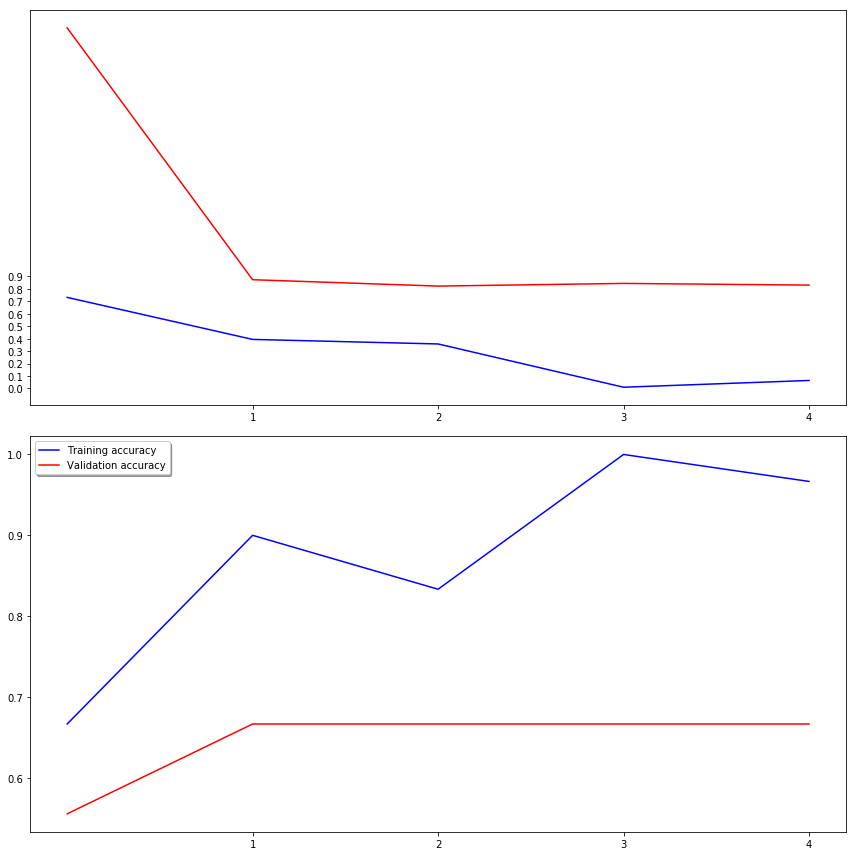

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Insert test.pkl file as credentials. Data includes 6 images for three classes

In [25]:
cos.download_file(Bucket=credentials['BUCKET'],Key='test.pkl',Filename='/home/dsxuser/work/test.pkl')

## Unpickle the data

In [26]:
pkl_file = open('test.pkl', 'rb')

test_data = pickle.load(pkl_file)
pkl_file.close()

In [27]:
testx, testy = test_data

In [28]:
testy = to_categorical(testy)

## Make Predictions on test data without data augmentation

In [29]:
test_results = model.predict(testx, 1)

In [30]:
test_results = np.argmax(test_results,axis=1)
print(test_results)

[0 0 1 1 2 2]


In [31]:
orig_testy = np.argmax(testy,axis=1)
print(orig_testy)

[0 0 1 1 2 2]


## Test the accuracy

In [32]:
scores = model.evaluate(testx, testy, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', "{:.2%}".format(scores[1]))

6/6 [==============================] - 1s 231ms/step
Test loss: 0.1297433227300644
Test accuracy: 100.00%


### The model has achieved 100% accuracy on the test data. 

### Save the model to work directory

In [33]:
model.save( "image-classification-model_new.h5" )

## Convert the model file to tgz format which is for keras model

In [34]:
!tar -zcvf image-classification-model_new.tgz image-classification-model_new.h5

image-classification-model_new.h5


## List the files in the directory

In [35]:
ls -1

image-classification-model_new.h5
image-classification-model_new.tgz
test.pkl
train.pkl
validation.pkl


## Create a Watson Machine Learning client instance

In [39]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
wml_credentials = {
    "instance_id": " ",
    "password"   : " ",
    "url"        : " ",
    "username"   : " "
}
client = WatsonMachineLearningAPIClient( wml_credentials )

## Store the model in the Watson Machine Learning repository

In [40]:
metadata = {
    client.repository.ModelMetaNames.AUTHOR_NAME         : "Sharath Kumar RK",
    client.repository.ModelMetaNames.NAME                : "Keras Model",
    client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES : [{'name':'keras', 'version': '2.2.4'}],
    client.repository.ModelMetaNames.FRAMEWORK_NAME      : "tensorflow",
    client.repository.ModelMetaNames.FRAMEWORK_VERSION   : "1.5",
    client.repository.ModelMetaNames.RUNTIME_NAME        : "python",
    client.repository.ModelMetaNames.RUNTIME_VERSION     : "3.6"
    
}
model_details = client.repository.store_model( model="image-classification-model_new.tgz", meta_props=metadata )

## Deploy the stored model as an online web service deployment

In [41]:
model_id = model_details["metadata"]["guid"]
deployment_details = client.deployments.create( artifact_uid=model_id, name="Keras Deployment" )



#######################################################################################

Synchronous deployment creation for uid: '6778573d-af72-404d-9005-7b88b1fd3e4f' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS..........
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='68f503eb-98c7-40b0-a910-5949d391090a'
------------------------------------------------------------------------------------------------




## Test the deployment

In [42]:
model_endpoint_url = client.deployments.get_scoring_url( deployment_details )
payload = { "values" : testx.tolist() }
client.deployments.score( model_endpoint_url, payload )

{'fields': ['prediction', 'prediction_classes', 'probability'],
 'values': [[[0.9814540147781372, 0.00459965318441391, 0.01394633948802948],
   0,
   [0.9814540147781372, 0.00459965318441391, 0.01394633948802948]],
  [[0.998604953289032, 0.00023022900859359652, 0.0011648599756881595],
   0,
   [0.998604953289032, 0.00023022900859359652, 0.0011648599756881595]],
  [[0.01823248155415058, 0.7986494302749634, 0.1831180900335312],
   1,
   [0.01823248155415058, 0.7986494302749634, 0.1831180900335312]],
  [[5.272458110994194e-06, 0.999981164932251, 1.3540889085561503e-05],
   1,
   [5.272458110994194e-06, 0.999981164932251, 1.3540889085561503e-05]],
  [[0.4029522240161896, 0.00030709095881320536, 0.5967406630516052],
   2,
   [0.4029522240161896, 0.00030709095881320536, 0.5967406630516052]],
  [[0.016650782898068428, 0.00042165766353718936, 0.9829276204109192],
   2,
   [0.016650782898068428, 0.00042165766353718936, 0.9829276204109192]]]}

## Print the deployment URL

In [43]:
print(model_endpoint_url)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/2013b168-619e-45fc-87c9-e06939c42cad/deployments/68f503eb-98c7-40b0-a910-5949d391090a/online


## Summary

#### In this notebook, we have learnt how to create & train a keras model, make predictions and evaluate the accuracy. We have also learnt how to save the model to Watson Machine Learning repository and enable online deployment for scoring.

## Author

**Sharath Kumar RK**, Data Scientist, IBM India Software Labs